In [6]:
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np

In [7]:
NUM_QUBITS = 2
dev = qml.device("default.qubit", wires=NUM_QUBITS)
wires = list(range(NUM_QUBITS))


def equal_superposition(wires):
    for wire in wires:
        qml.Hadamard(wires=wire)


@qml.qnode(dev)
def circuit():
    qml.Snapshot("Initial state")
    equal_superposition(wires)
    qml.Snapshot("After applying the Hadamard gates")
    return qml.probs(wires=wires)  # Probability of finding a computational basis state on the wires


results = qml.snapshots(circuit)()

for k, result in results.items():
    print(f"{k}: {result}")

Initial state: [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
After applying the Hadamard gates: [0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]
execution_results: [0.25 0.25 0.25 0.25]


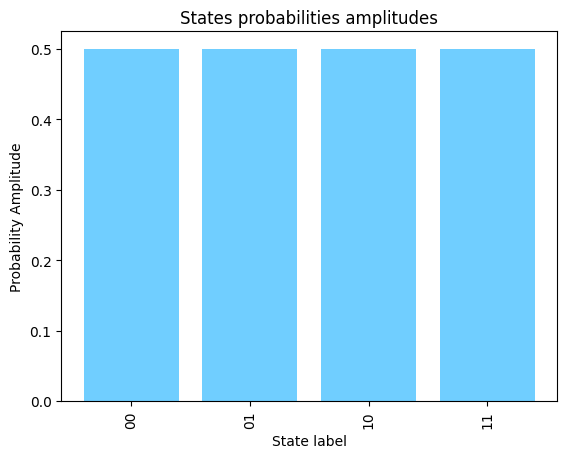

In [8]:
y = np.real(results["After applying the Hadamard gates"])
bit_strings = [f"{x:0{NUM_QUBITS}b}" for x in range(len(y))]

plt.bar(bit_strings, y, color = "#70CEFF")

plt.xticks(rotation="vertical")
plt.xlabel("State label")
plt.ylabel("Probability Amplitude")
plt.title("States probabilities amplitudes")
plt.show()

Initial state |00>: [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
After flipping it: [-1.+0.j  0.+0.j  0.+0.j  0.+0.j]
execution_results: [-1.+0.j  0.+0.j  0.+0.j  0.+0.j]


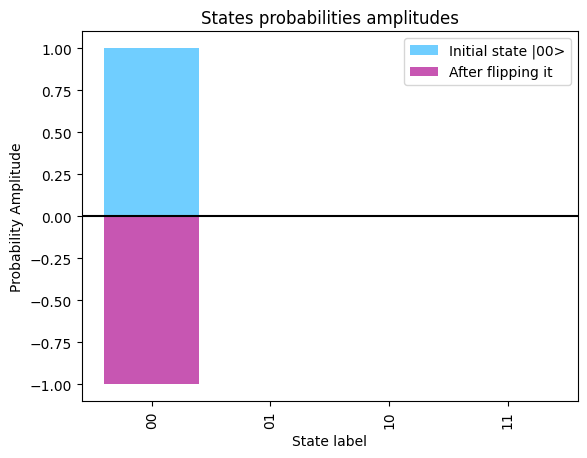

In [9]:
dev = qml.device("default.qubit", wires=NUM_QUBITS)

@qml.qnode(dev)
def circuit():
    qml.Snapshot("Initial state |00>")
    # Flipping the marked state
    qml.FlipSign([0, 0], wires=wires)
    qml.Snapshot("After flipping it")
    return qml.state()

results = qml.snapshots(circuit)()

for k, result in results.items():
    print(f"{k}: {result}")

y1 = np.real(results["Initial state |00>"])
y2 = np.real(results["After flipping it"])

bit_strings = [f"{x:0{NUM_QUBITS}b}" for x in range(len(y))]

plt.bar(bit_strings, y1, color = "#70CEFF")
plt.bar(bit_strings, y2, color = "#C756B2")

plt.xticks(rotation="vertical")
plt.xlabel("State label")
plt.ylabel("Probability Amplitude")
plt.title("States probabilities amplitudes")

plt.legend(["Initial state |00>", "After flipping it"])
plt.axhline(y=0.0, color="k", linestyle="-")
plt.show()

In [10]:
omega = np.zeros(NUM_QUBITS)

def oracle(wires, omega):
    qml.FlipSign(omega, wires=wires)

dev = qml.device("default.qubit", wires=NUM_QUBITS)

@qml.qnode(dev)
def circuit():
    equal_superposition(wires)
    qml.Snapshot("Before querying the Oracle")

    oracle(wires, omega)
    qml.Snapshot("After querying the Oracle")

    return qml.probs(wires=wires)

results = qml.snapshots(circuit)()

for k, result in results.items():
    print(f"{k}: {result}")

Before querying the Oracle: [0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]
After querying the Oracle: [-0.5+0.j  0.5+0.j  0.5+0.j  0.5+0.j]
execution_results: [0.25 0.25 0.25 0.25]


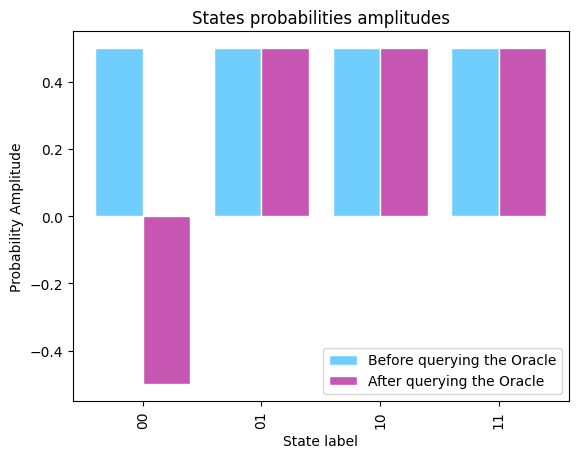

In [11]:
y1 = np.real(results["Before querying the Oracle"])
y2 = np.real(results["After querying the Oracle"])

bit_strings = [f"{x:0{NUM_QUBITS}b}" for x in range(len(y1))]

bar_width = 0.4

rect_1 = np.arange(0, len(y1))
rect_2 = [x + bar_width for x in rect_1]

plt.bar(
    rect_1,
    y1,
    width=bar_width,
    edgecolor="white",
    color = "#70CEFF",
    label="Before querying the Oracle",
)
plt.bar(
    rect_2,
    y2,
    width=bar_width,
    edgecolor="white",
    color = "#C756B2",
    label="After querying the Oracle",
)

plt.xticks(rect_1 + 0.2, bit_strings, rotation="vertical")
plt.xlabel("State label")
plt.ylabel("Probability Amplitude")
plt.title("States probabilities amplitudes")

plt.legend()
plt.show()

In [12]:
dev = qml.device("default.qubit", wires=NUM_QUBITS)


def diffusion_operator(wires):
    for wire in wires:
        qml.Hadamard(wires=wire)
        qml.PauliZ(wires=wire)
    qml.ctrl(qml.PauliZ, 0)(wires=1)
    for wire in wires:
        qml.Hadamard(wires=wire)


@qml.qnode(dev)
def circuit():
    equal_superposition(wires)
    qml.Snapshot("Uniform superposition |s>")

    oracle(wires, omega)
    qml.Snapshot("State marked by Oracle")
    diffusion_operator(wires)

    qml.Snapshot("Amplitude after diffusion")
    return qml.probs(wires=wires)


results = qml.snapshots(circuit)()

for k, result in results.items():
    print(f"{k}: {result}")

Uniform superposition |s>: [0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]
State marked by Oracle: [-0.5+0.j  0.5+0.j  0.5+0.j  0.5+0.j]
Amplitude after diffusion: [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
execution_results: [1. 0. 0. 0.]


In [13]:
NUM_QUBITS = 5

omega = np.array([np.zeros(NUM_QUBITS), np.ones(NUM_QUBITS)])

M = len(omega)
N = 2**NUM_QUBITS
wires = list(range(NUM_QUBITS))

dev = qml.device("default.qubit", wires=NUM_QUBITS)

@qml.qnode(dev)
def circuit():
    iterations = int(np.round(np.sqrt(N / M) * np.pi / 4))

    # Initial state preparation
    equal_superposition(wires)

    # Grover's iterator
    for _ in range(iterations):
        for omg in omega:
            oracle(wires, omg)
        qml.templates.GroverOperator(wires)

    return qml.probs(wires=wires)


results = qml.snapshots(circuit)()

for k, result in results.items():
    print(f"{k}: {result}")

execution_results: [0.48065948 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937
 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937
 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937
 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937
 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937
 0.00128937 0.48065948]


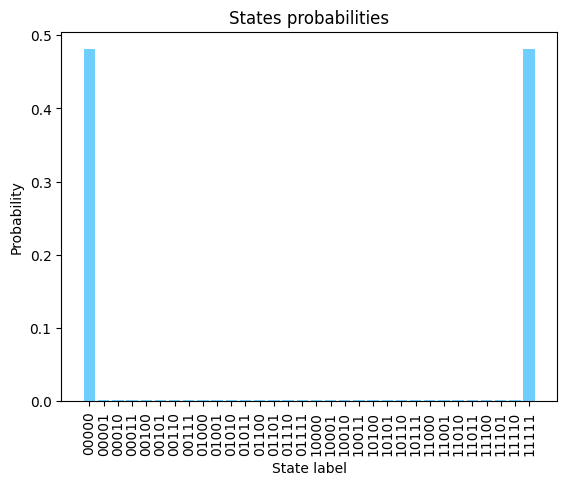

In [14]:
y = results["execution_results"]
bit_strings = [f"{x:0{NUM_QUBITS}b}" for x in range(len(y))]

plt.bar(bit_strings, results["execution_results"], color = "#70CEFF")

plt.xticks(rotation="vertical")
plt.xlabel("State label")
plt.ylabel("Probability")
plt.title("States probabilities")

plt.show()

In [15]:
n_wires = 3
wires = list(range(n_wires))

def oracle():
    qml.Hadamard(wires[-1])
    qml.Toffoli(wires=wires)
    qml.Hadamard(wires[-1])

In [16]:
dev = qml.device('default.qubit', wires=wires)

@qml.qnode(dev)
def GroverSearch(num_iterations=1):
    for wire in wires:
        qml.Hadamard(wire)

    for _ in range(num_iterations):
        oracle()
        qml.templates.GroverOperator(wires=wires)
    return qml.probs(wires)

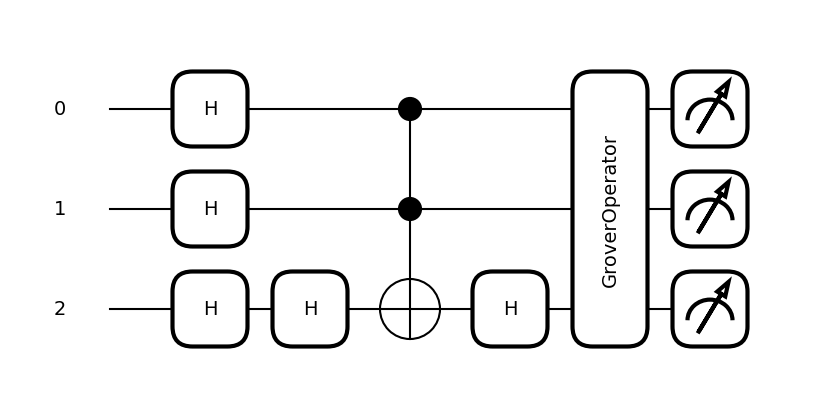

In [20]:
fig, axs = qml.draw_mpl(GroverSearch)(1)

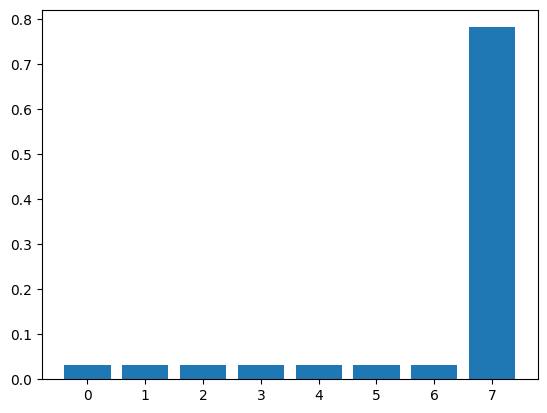

In [21]:
result = GroverSearch(num_iterations=1)
plt.bar(range(len(result)),result)
plt.show()

In [ ]:
basis_state = [1, 0]

dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def circuit():
    for wire in list(range(2)):
        qml.Hadamard(wires=wire)
    qml.FlipSign(basis_state, wires=list(range(2)))
    return qml.state()

circuit()

In [34]:
U = qml.Hadamard(wires=0)
dev = qml.device('default.qubit')

@qml.qnode(dev)
def circuit():
    qml.PauliX(wires=0)
    qml.Reflection(U)
    return qml.state()

circuit()

array([1.+6.123234e-17j, 0.-6.123234e-17j])

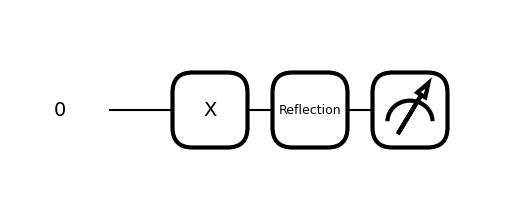

In [35]:
fig, axs = qml.draw_mpl(circuit)()

In [ ]:
@qml.prod
def U(wires):
    qml.Hadamard(wires=wires[0])
    qml.RY(0.1, wires=wires[1])

@qml.qnode(dev)
def circuit():
    qml.Reflection(U([0, 1]))
    return qml.state()

circuit()